In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# load in the data
data_path = "data/vgsales.csv"
vg_sales = pd.read_csv(data_path)
vg_sales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


<IPython.core.display.Javascript object>

In [3]:
# drop wii sports
vg_sales = vg_sales[vg_sales["Name"] != "Wii Sports"]

<IPython.core.display.Javascript object>

In [4]:
# create 'decade' field for each game
eighties = list(range(1980, 1990))
nineties = list(range(1990, 2000))
oughts = list(range(2000, 2010))
tens = list(range(2010, 2020))
twenties = list(range(2020, 2030))

vg_sales["decade"] = "80s"
vg_sales.loc[vg_sales["Year"].isin(nineties), "decade"] = "90s"
vg_sales.loc[vg_sales["Year"].isin(oughts), "decade"] = "00s"
vg_sales.loc[vg_sales["Year"].isin(tens), "decade"] = "10s"
vg_sales.loc[vg_sales["Year"].isin(twenties), "decade"] = "20s"

<IPython.core.display.Javascript object>

In [5]:
# select 2000-2019
vg_00_10 = vg_sales[vg_sales["decade"] != "80s"]
vg_00_10 = vg_00_10[vg_00_10["decade"] != "20s"]
vg_00_10 = vg_00_10[vg_00_10["decade"] != "90s"]
vg_00_10.decade.value_counts()

00s    9207
10s    5144
Name: decade, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
vg_00_10.isna().sum()

Rank             0
Name             0
Platform         0
Year             0
Genre            0
Publisher       36
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Global_Sales     0
decade           0
dtype: int64

<IPython.core.display.Javascript object>

In [7]:
# remove entries with zero 'NA_Sales'
vg_00_10 = vg_00_10[vg_00_10["NA_Sales"] > 0]
vg_00_10 = vg_00_10.dropna()
vg_00_10.decade.value_counts()

00s    7381
10s    3191
Name: decade, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
vg_00_10.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,decade
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,00s
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,00s
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,00s
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,00s
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62,00s


<IPython.core.display.Javascript object>

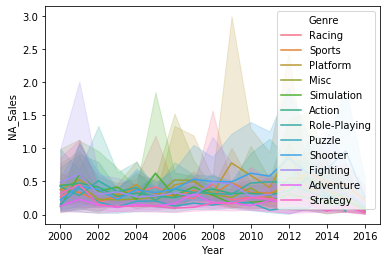

<IPython.core.display.Javascript object>

In [9]:
sns.lineplot("Year", "NA_Sales", hue="Genre", ci=100, data=vg_00_10)
# make line graphs for each sig pair from posthoc testing

In [18]:
vg_00_10["log_na_sales"] = np.log(vg_00_10["NA_Sales"])

<IPython.core.display.Javascript object>

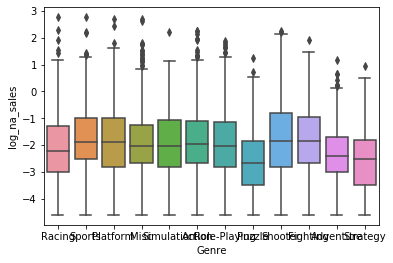

<IPython.core.display.Javascript object>

In [19]:
sns.boxplot("Genre", "log_na_sales", data=vg_00_10)

In [20]:
np.exp(np.log(635841))
# undoes nat log np.log
# run tukey, then exponemntiate ci bounds

635840.9999999999

<IPython.core.display.Javascript object>

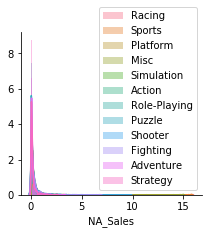

<IPython.core.display.Javascript object>

In [21]:
fg = sns.FacetGrid(data=vg_00_10, hue="Genre")
fg.map(sns.distplot, "NA_Sales")
plt.legend()
plt.show()

In [22]:
# separate based on genres.
sports = vg_00_10[vg_00_10["Genre"] == "Sports"]
action = vg_00_10[vg_00_10["Genre"] == "Action"]
misc = vg_00_10[vg_00_10["Genre"] == "Misc"]
rpg = vg_00_10[vg_00_10["Genre"] == "Role-Playing"]
adventure = vg_00_10[vg_00_10["Genre"] == "Adevnture"]
shooter = vg_00_10[vg_00_10["Genre"] == "Shooter"]
racing = vg_00_10[vg_00_10["Genre"] == "Racing"]
sim = vg_00_10[vg_00_10["Genre"] == "Simulation"]
platform = vg_00_10[vg_00_10["Genre"] == "Platform"]
fighting = vg_00_10[vg_00_10["Genre"] == "Fighting"]
strategy = vg_00_10[vg_00_10["Genre"] == "Strategy"]
puzzle = vg_00_10[vg_00_10["Genre"] == "Puzzle"]

<IPython.core.display.Javascript object>

In [23]:
print(sports["NA_Sales"].shape)
print(action["NA_Sales"].shape)
print(misc["NA_Sales"].shape)
print(rpg["NA_Sales"].shape)
print(adventure["NA_Sales"].shape)
print(shooter["NA_Sales"].shape)
print(racing["NA_Sales"].shape)
print(sim["NA_Sales"].shape)
print(platform["NA_Sales"].shape)
print(fighting["NA_Sales"].shape)
print(strategy["NA_Sales"].shape)
print(puzzle["NA_Sales"].shape)

# there are no adventure games released in these years in this data.

(1600,)
(2324,)
(1092,)
(778,)
(0,)
(997,)
(931,)
(558,)
(663,)
(473,)
(280,)
(382,)


<IPython.core.display.Javascript object>

In [27]:
# test distributions for normality
# vg_00_10.groupby("Genre").hist(column="log_na_sales")


<IPython.core.display.Javascript object>

In [25]:
stats.f_oneway(
    sports["log_na_sales"],
    action["log_na_sales"],
    misc['log_na_sales'],
    rpg["log_na_sales"],
    shooter["log_na_sales"],
    racing["log_na_sales"],
    sim["log_na_sales"],
    platform["log_na_sales"],
    fighting["log_na_sales"],
    strategy["log_na_sales"],
    puzzle["log_na_sales"],
)


F_onewayResult(statistic=22.94814618074259, pvalue=3.663062209489204e-43)

<IPython.core.display.Javascript object>

sports x action
sports x rpg
sports x shooter
sports x racing
sports x sim
sports x platform
sports x fighting
sports x strategy
sports x puzzle

action x rpg
action x shooter
action x racing
action x sim
action x platform
action x fighting
action x strategy
action x puzzle

rpg x shooter
rpg x racing
rpg x sim
rpg x platform
rpg x fighting
rpg x strategy
rpg x puzzle

shooter x racing
shooter x sim
shooter x platform
shooter x fighting
shooter x strategy
shooter x puzzle

racing x sim
racing x platform
racing x fighting
racing x strategy
racing x puzzle

sim x platform
sim x fighting
sim x strategy
sim x puzzle

platform x fighting
platform x strategy
platform x puzzle

fighting x strategy
fighting x puzzle

strategy x puzzle

